In [3]:
import numpy as np
from matplotlib import pyplot as plt
import time

### Synthetic Cases

- Case 1: normal glacier (seasonal speedup/slowdown)
- Case 2: surging glacier
- Case 3: weird glacier (with highly variable velocities)
- Case 4: glacier with increasing velocities over time

In [4]:
# Choose the amount of samples you have
N = 50

# The higher the lambda, the more smoothing you force. 
lamb = 5

# Choose a case
case_number = 1

In [5]:
# generate a time series for time and velocities
# this will be the synthetic data set
def case(case_number):
    
    t = np.arange(0,10*360)
    
    # Create a basic glacier function
    v = 500+400*np.sin(2*np.pi*t/360)
    
    if case_number == 1:
        v = v
    
    elif case_number == 2:   
        nodes = [180*n for n in range(20)]
        surge = 500+3000*np.sin(2*np.pi*t[:180]/360)
        v[nodes[10]:nodes[11]] = surge

    elif case_number == 3:
        
        nodes = [180*n for n in range(20)]
    
        # Create random variations of the signal
        variations = np.random.randint(0,500,20)

        # Create a glacier function
        v = np.zeros(t.shape[0])
        for i in range(len(variations)):
            v[i*180:(i+1)*180] = 500+variations[i]*np.sin(2*np.pi*t[i*180:(i+1)*180]/360)    
        
    elif case_number == 4:
        v += np.linspace(1, 10, 10*360)
        
    plt.plot(t,v)
    plt.title('True Velocities')
    plt.xlabel('Time')
    plt.ylabel('Velocities')
    
    return v, t

In [38]:
def random_sample(t, v, N):

    A_m = np.zeros([N,np.size(v)])
    vObs = np.zeros(N)
    mid_date = np.zeros(N)
    im1 = np.zeros(N)
    im2 = np.zeros(N)

    M = np.size(v)

    for n in range(N):
        sample = np.sort(np.random.randint(0,M,(2)))
        # Randomly select 2 satellite images, make sure sample[1] > sample[0]
        while sample[1]-sample[0]==0:
            sample = np.sort(np.random.randint(0,M,(2)))

        # Store the indices of the samples (im1 and im2)
        im1[n] = sample[0]
        im2[n] = sample[1]
        mid_date[n] = np.mean(sample)
        

        # Plug in the design matrix the contribution of each time sample to the average velocity measured (convex sum)
        A_m[n,sample[0]:sample[1]] = 1/(sample[1]-sample[0])

        # Get the average velocity between im1 and im2
        vObs[n] = np.mean(v[sample[0]:sample[1]])

    # Get the sorted indices of im1 (from old to recent)
    inds_sort = np.argsort(mid_date)

    # Sort in time the measurements
    im1 = im1[inds_sort]
    im2 = im2[inds_sort]
    vObs = vObs[inds_sort]
    A_m = A_m[inds_sort]
    mid_date = mid_date[inds_sort]

    return A_m, vObs, im1, im2, mid_date


def invert(A_m, vObs, lamb = 100):

    M=np.shape(A_m)[1]

    # Construct temporal regularization matrix
    reg_mat_time = np.zeros((A_m.shape[1]-2, A_m.shape[1]))
    for j in range(A_m.shape[1] -2):
        reg_mat_time[j, j] = lamb
        reg_mat_time[j, j+1] = -2*lamb
        reg_mat_time[j, j+2] = lamb
        
    # Assemble the design matrix
    A_des = np.vstack((A_m, reg_mat_time))
    
    # Extend the vector of observed velocities
    vObs = np.hstack((vObs, np.zeros(reg_mat_time.shape[0])))

    # vm is the interpolated (modeled) velocity
    vm = np.linalg.solve(A_des.T@A_des, A_des.T@vObs)
    
    return vm



def Runner(N, lamb, case):
    
    # generate random samples
    A_m, vObs, im1, im2, mid_date = random_sample(t,v,N)
    
    # Inversion 1
    start_time = time.time()
    vm = invert(A_m, vObs, lamb)
    end_time = time.time()
    print(f"Inversion took: {end_time - start_time:.5f} seconds")
    
    plt.figure()
    plt.plot(t,v, label='true velocities')
    plt.plot(t[1:-1],vm[1:-1], label='reconstructed velocities')
    for n in range(N):
        plt.plot(np.array([im1[n], im2[n]]), [vObs[n],vObs[n]], 'r', alpha = 0.3)
        plt.plot(mid_date[n], vObs[n], 'ro', alpha = 0.3)
        if n == 0:
            plt.plot(np.array([im1[n], im2[n]]), [vObs[n],vObs[n]], 'r', alpha = 0.3, label = 'timespan of image pair')
            plt.plot(mid_date[n], vObs[n], 'ro', alpha = 0.3, label = 'date attribution')            
    plt.legend(loc = 'upper left')
    plt.title(f'Velocity Inversion with {N} samples')
    plt.xlabel('Time')
    plt.ylabel('Velocities')
    plt.savefig(f'./figs/Synthetic_{case}_{N}.png', dpi = 600)
    
    return vm, im1, im2, mid_date, vObs

In [39]:
# Choose the amount of samples you have
N = 50

# The higher the lambda, the more smoothing you force. 
lamb = 5

# Choose a case
case_number = 2

Inversion took: 1.14162 seconds


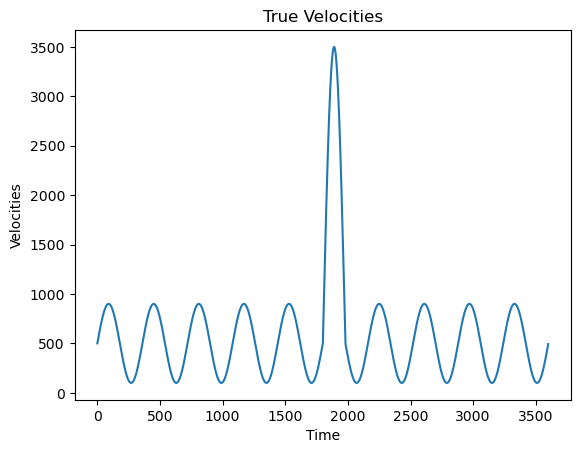

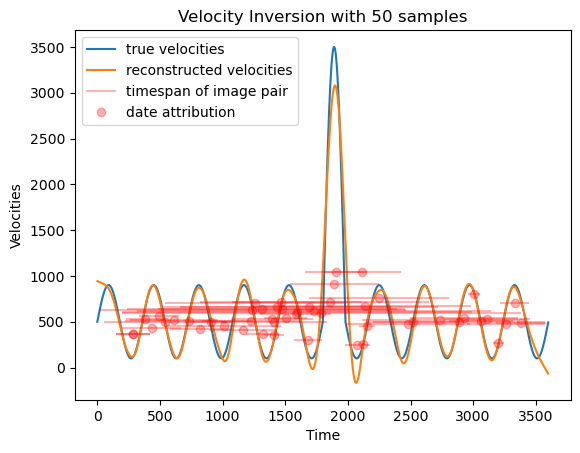

In [40]:
v, t = case(case_number)
A_m, vObs, im1, im2, mid_date = random_sample(t, v, N)
vm, im1, im2, mid_date, vObs = Runner(N, lamb, case_number)